In [6]:
#make velocity traces for every session
import sys
sys.path.append('../../../src/')

import os
from typing import Dict
from os import PathLike
from pathlib import Path
import csv 

from aind_vr_foraging_analysis import utils
from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns
import pandas as pd
import numpy as np
import datetime

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle
from scipy.signal import find_peaks, butter, lfilter


colors = sns.color_palette()
odor_list_color = [colors[8], colors[0], colors[2], colors[4]]

base_path = r'/Volumes/aind/scratch/vr-foraging/data'
foraging_figures = r'/Users/nehal.ajmal/Documents/aindproject/analysis_files'

from scipy.optimize import curve_fit
 
# Define constants
mouse_id = '745305'
color_dict_label = {}
label_dict = {"InterSite": '#808080', "InterPatch": '#b3b3b3'}

# Define paths
base_output_dir = '/Users/nehal.ajmal/Documents/aindproject/analysis_files' 

# Create a subfolder for the mouse if it doesn't exist
mouse_output_dir = os.path.join(base_output_dir, mouse_id)
os.makedirs(mouse_output_dir, exist_ok=True)


In [7]:

# Function to identify peaks and troughs
#neds to be modified to filter peaks when signal is bad
def identify_peaks_and_troughs(data, width_peaks=5, prominence_peaks=0.1, width_troughs=3, prominence_troughs=0.1):
    data = data.dropna()
    data = data[~data.index.duplicated(keep='first')]
    data = data.sort_index()
    data_values = data.values.squeeze()
    peaks, _ = find_peaks(data_values, width=width_peaks, prominence=prominence_peaks)
    troughs, _ = find_peaks(-data_values, width=width_troughs, prominence=prominence_troughs)
    troughs = troughs[troughs > peaks[0]]
    peak_times = data.index[peaks]
    trough_times = data.index[troughs]
    return peak_times, trough_times


In [8]:

# Function to align sniff peaks with rewards
def align_sniff_peaks_with_rewards(stream_data, reward_sites, width_peaks=5, prominence_peaks=0.1, width_troughs=3, prominence_troughs=0.1):
    sniff_aligned = reward_sites.copy()
    peak_times, trough_times = identify_peaks_and_troughs(stream_data.breathing, width_peaks, prominence_peaks, width_troughs, prominence_troughs)
    first_peaks = [np.searchsorted(peak_times, start_time) for start_time in sniff_aligned.index]
    first_sniff_peak_start_time = [peak_times[fp] for fp in first_peaks]
    sniff_aligned['first_sniff_peak'] = first_sniff_peak_start_time
    sniff_aligned = sniff_aligned.set_index('first_sniff_peak')
    sniff_aligned.index.name = 'times'
    return sniff_aligned


In [11]:

# function to process each session
def process_session(session_path):
    session_id = session_path.split('/')[-1]
    print(f"Processing session: {session_id}")

    try:
        # Load data
        data = parse.load_session_data(session_path)
        reward_sites, active_site, config = parse.parse_dataframe(data)
        reward_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
        active_site = AddExtraColumns(reward_sites, active_site, run_on_init=False).add_time_previous_intersite_interpatch()
        active_site['next_intersite'] = active_site.index.to_series().shift(-1)
        reward_sites = active_site.loc[active_site['label']=='RewardSite']
        reward_sites['time_in_odor_site'] = reward_sites.next_intersite - reward_sites.index
        list_patches = parse.TaskSchemaProperties(data).patches
        for i, patches in enumerate(list_patches):
            color_dict_label[patches['label']] = odor_list_color[i]

        # Load the encoder data
        stream_data = parse.ContinuousData(data)
        encoder_data = stream_data.encoder_data

        # Align sniff peaks with rewards
        sniff_aligned = align_sniff_peaks_with_rewards(stream_data, reward_sites)

        # Plotting velocity traces
        trial_summary_running = plotting.trial_collection(reward_sites[['visit_number', 'odor_label', 'odor_sites']], encoder_data, mouse_id, session_id, window=(-2, 4))
        max_range = max(trial_summary_running.speed.values)
        y_min = 0 - 2
        y_max = max_range + 8
        plotting.velocity_traces_odor_entry(trial_summary_running, window=(-0.5, 0.5), y_lims=(y_min, y_max), color_dict_label=color_dict_label,
                                            cmap='magma', mean=True, save=False, n_sites=5, mouse=mouse_id, session=session_id)

        # Plotting breathing traces
        trial_summary_breathing = plotting.trial_collection(sniff_aligned[['has_choice', 'visit_number', 'odor_label', 'odor_sites', 'time_in_odor_site']], stream_data.breathing, mouse_id, session_id, window=(-2, 8), taken_col='data')
        y_max = trial_summary_breathing.data.max()
        y_min = trial_summary_breathing.data.min()
        plotting.velocity_traces_odor_entry(trial_summary_breathing, y_lims=(y_min, y_max), window=(-0.5, 0.5),
                                            color_dict_label=color_dict_label, cmap='magma',
                                            mean=True, save=False, n_sites=5, y='data', mouse=mouse_id, session=session_id, y_label='Amplitude (a.u.)')

    except Exception as e:
        print(f"Error processing session {session_id}: {e}")


Processing session: 745305_20240710T120912
Error processing session 745305_20240710T120912: Path /Volumes/aind/scratch/vr-foraging/data/745305/745305_20240710T120912/behavior/SoftwareEvents is not a directory
Processing session: 745305_20240710T121533


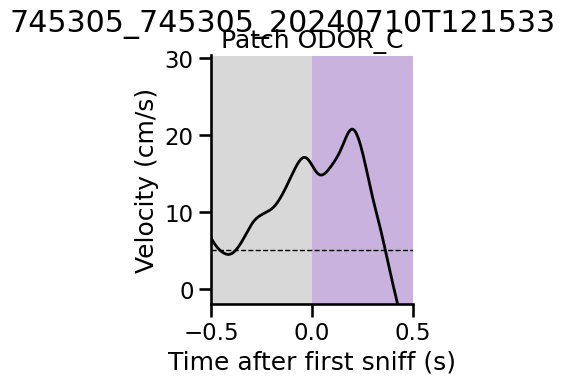

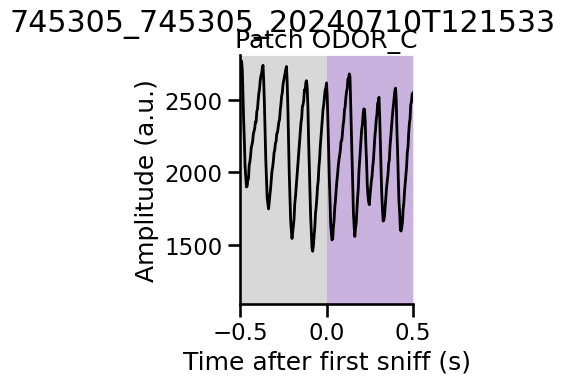

Processing session: 745305_20240711T113208
Error processing session 745305_20240711T113208: "None of ['Seconds'] are in the columns"
Processing session: 745305_20240711T114114


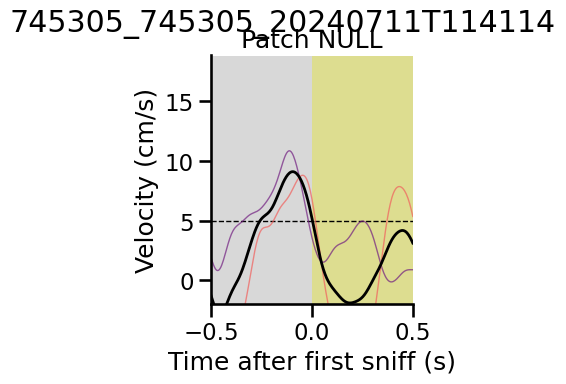

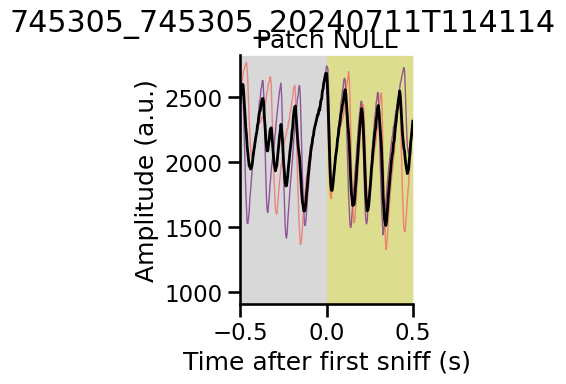

Processing session: 745305_20240712T101343


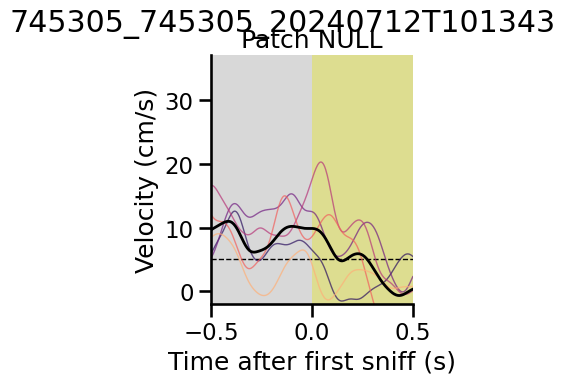

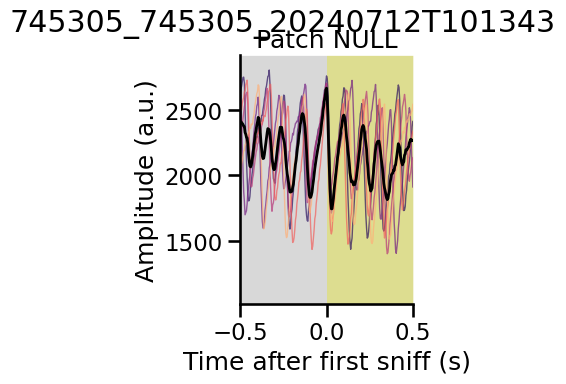

Processing session: 745305_20240712T155809


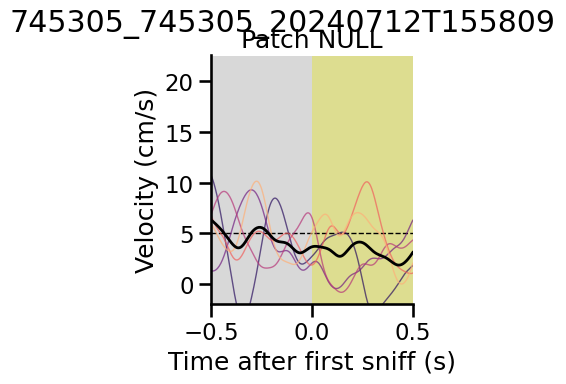

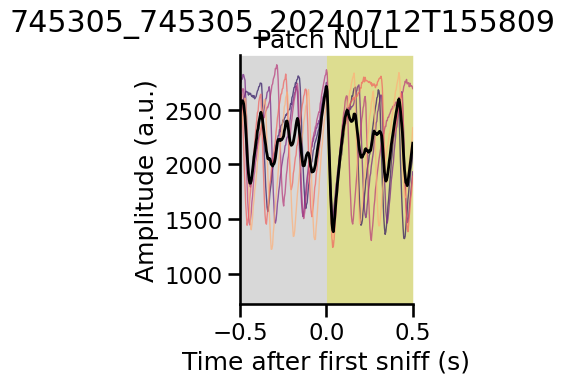

Processing session: 745305_20240713T120546
Error processing session 745305_20240713T120546: 'DataFrame' object has no attribute 'speed'
Processing session: 745305_20240715T103126
Error processing session 745305_20240715T103126: 'DataFrame' object has no attribute 'speed'
Processing session: 745305_20240715T140553
Error processing session 745305_20240715T140553: 'DataFrame' object has no attribute 'speed'
Processing session: 745305_20240715T152306
No reward sites found
Error processing session 745305_20240715T152306: 'reward_delivered'
Processing session: 745305_20240716T162026
No reward sites found
Error processing session 745305_20240716T162026: 'reward_delivered'
Processing session: 745305_20240717T153644
No reward sites found
Error processing session 745305_20240717T153644: 'reward_delivered'
Processing session: 745305_20240718T164457


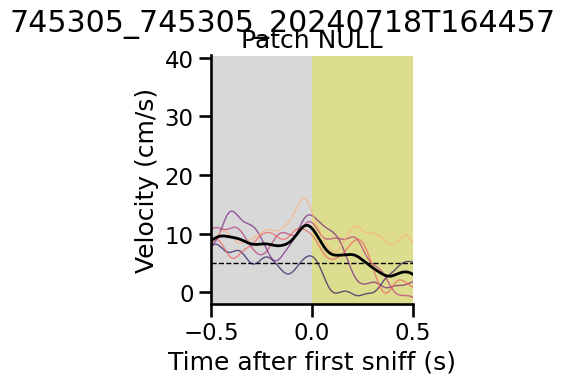

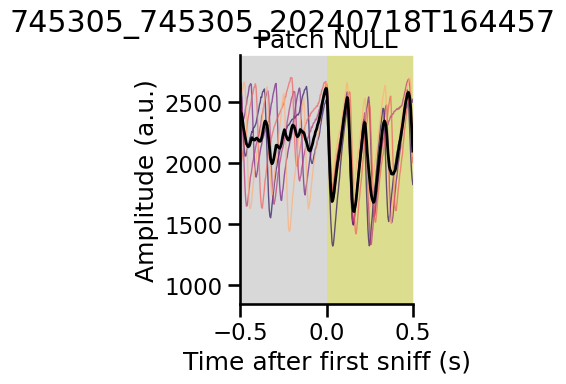

Processing session: 745305_20240719T102443
Error processing session 745305_20240719T102443: "None of ['Seconds'] are in the columns"
Processing session: 745305_20240719T102611


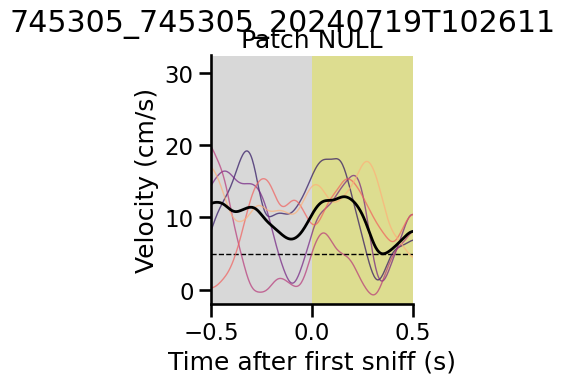

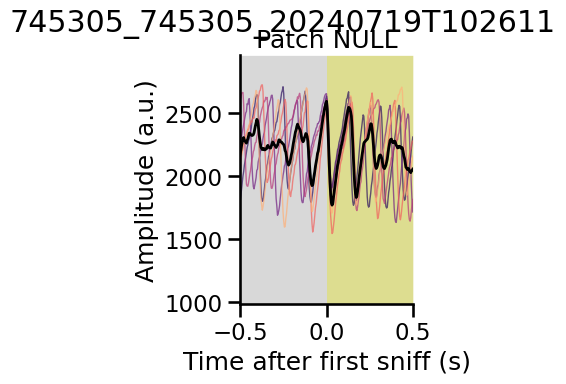

Processing session: 745305_20240722T091331


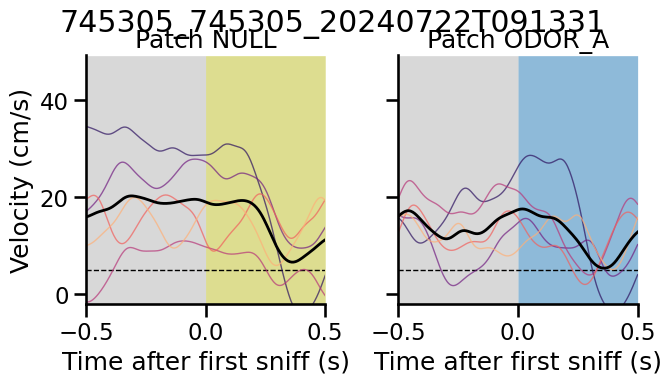

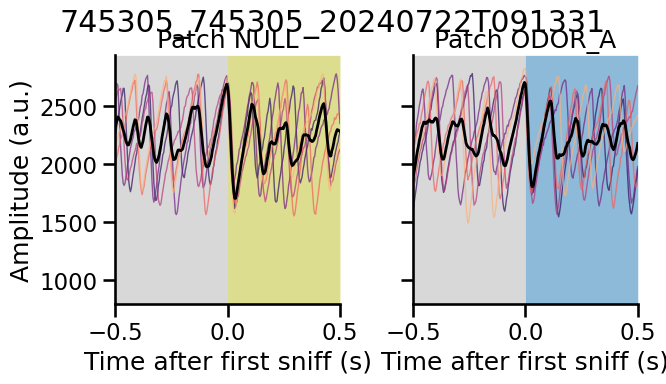

Processing session: 745305_20240723T091815
Error processing session 745305_20240723T091815: "None of ['Seconds'] are in the columns"
Processing session: 745305_20240723T092636
Error processing session 745305_20240723T092636: Path /Volumes/aind/scratch/vr-foraging/data/745305/745305_20240723T092636/behavior/SoftwareEvents is not a directory
Processing session: 745305_20240723T092940


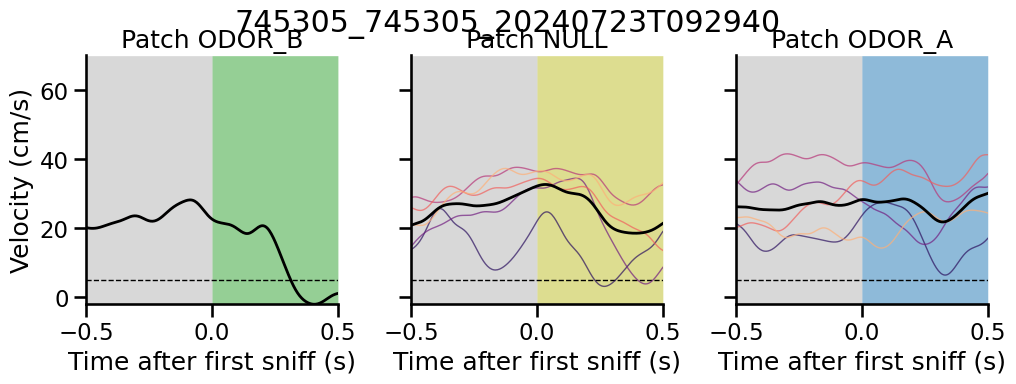

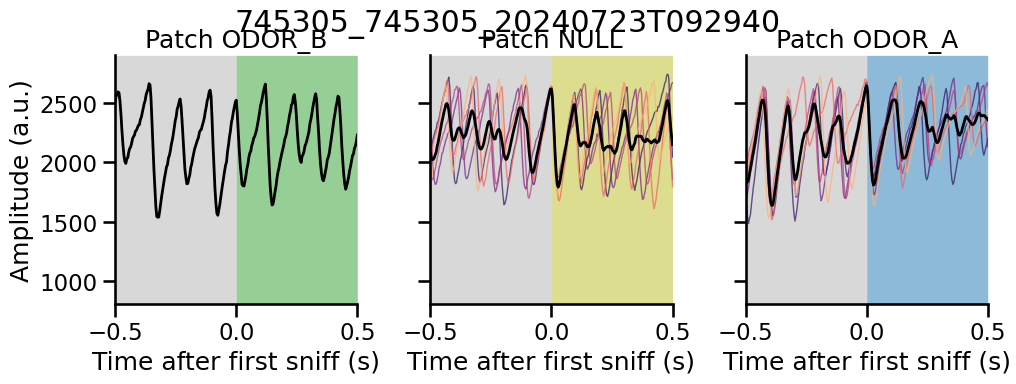

Processing session: 745305_20240724T090156


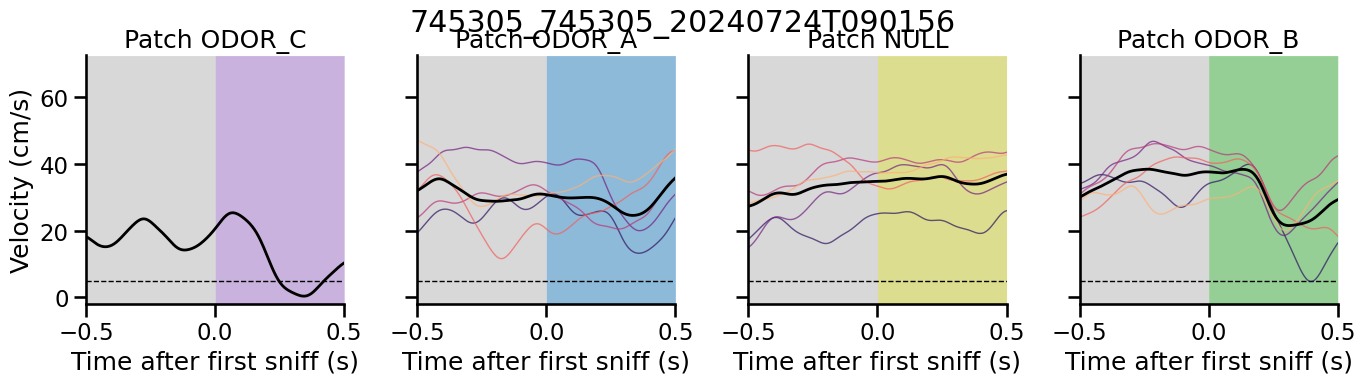

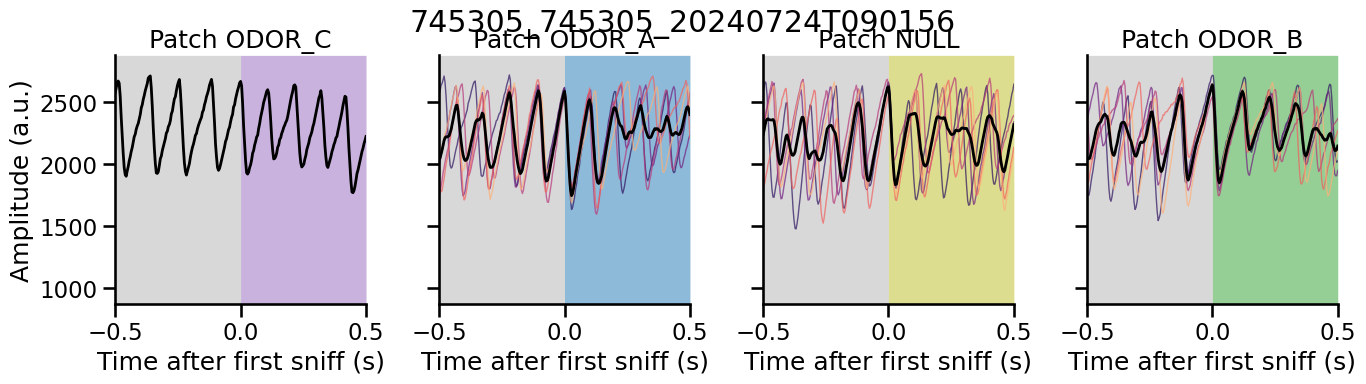

Processing session: 745305_20240725T095701


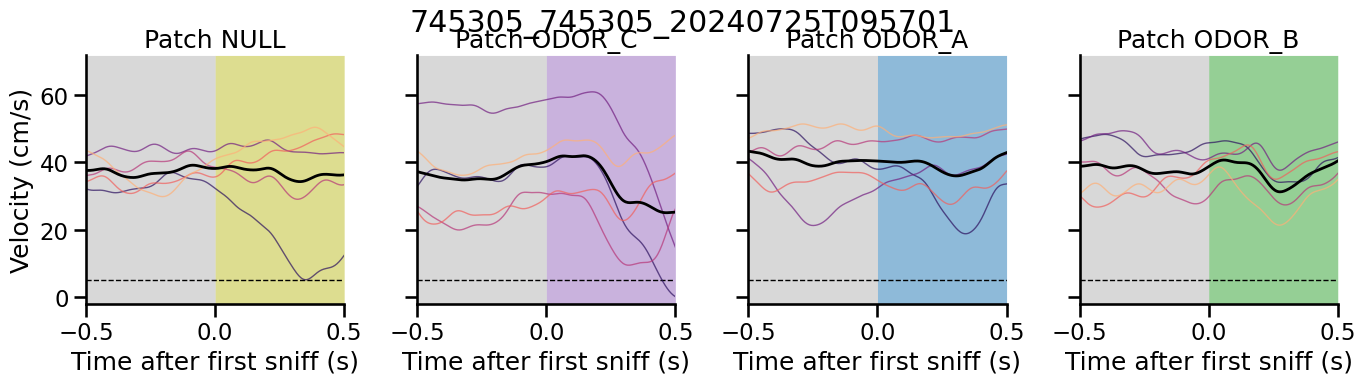

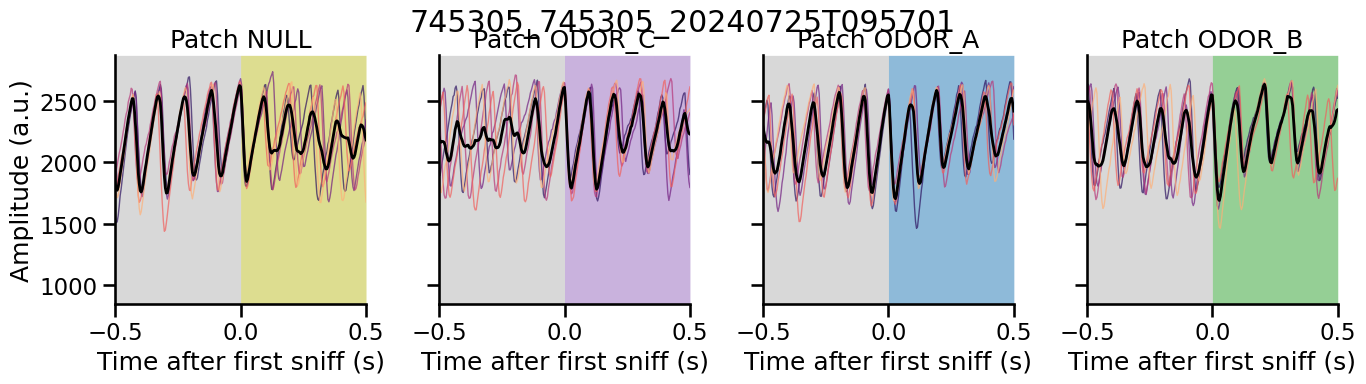

Processing session: 745305_20240726T083719


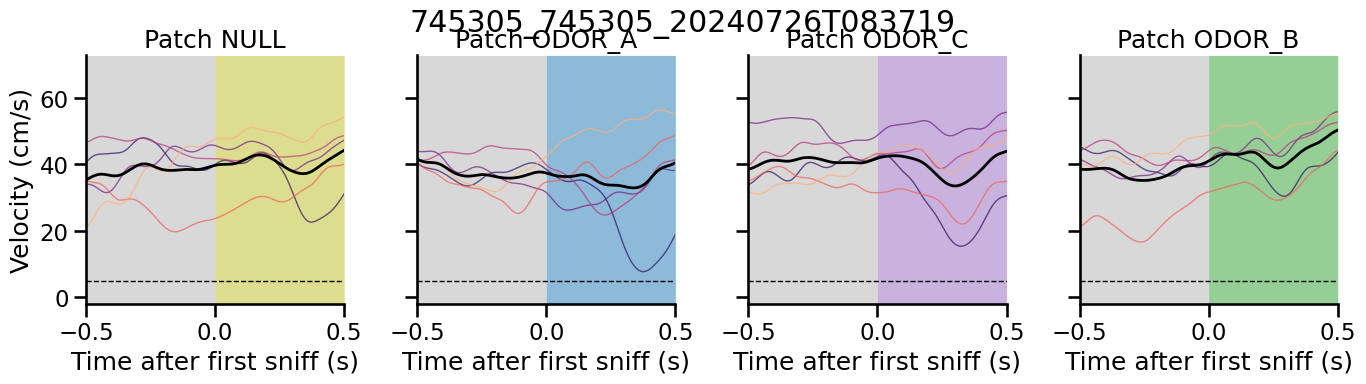

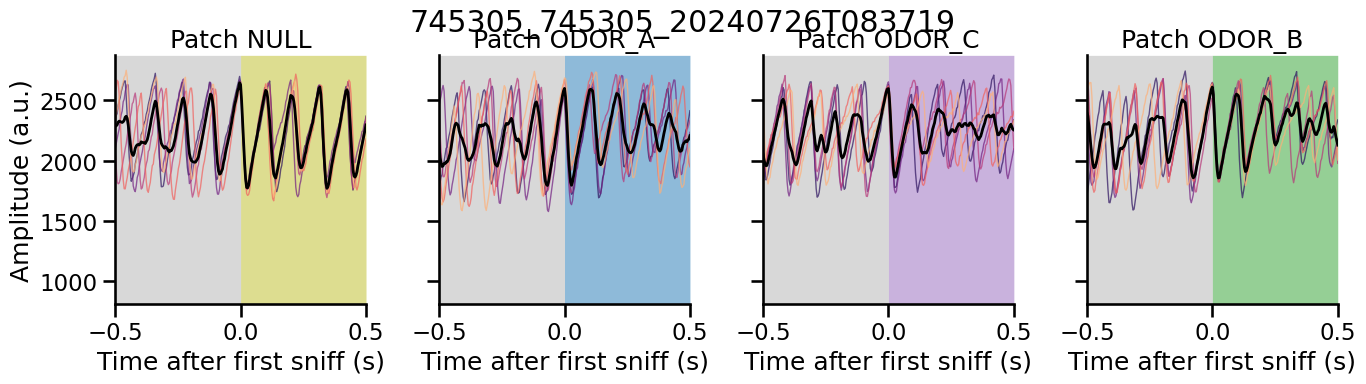

Processing session: 745305_20240730T083438


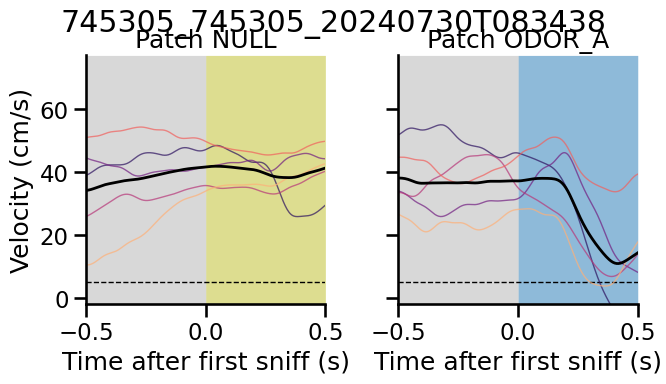

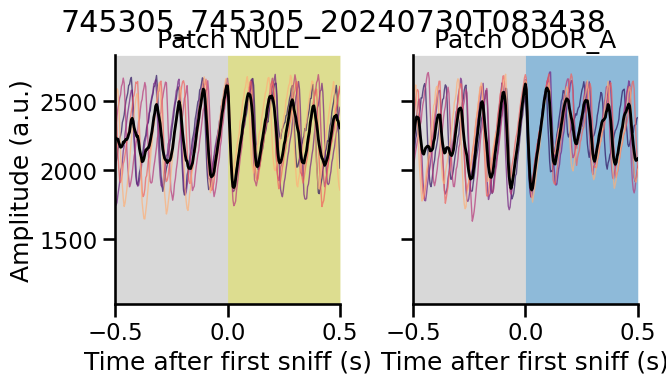

Processing session: 745305_20240730T085716
Error processing session 745305_20240730T085716: "None of ['Seconds'] are in the columns"
Processing session: 745305_20240730T085958
Error processing session 745305_20240730T085958: Unterminated string starting at: line 1 column 418 (char 417)
Processing session: 745305_20240731T082913


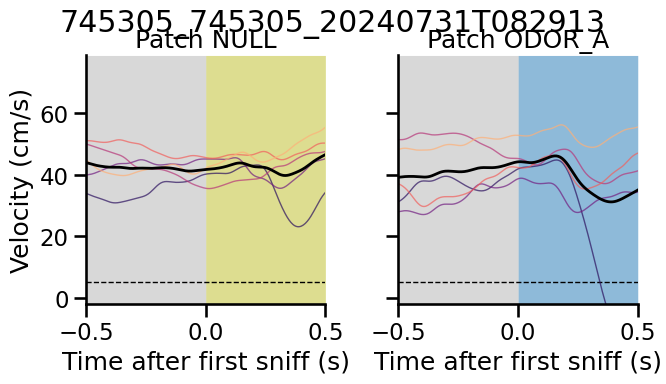

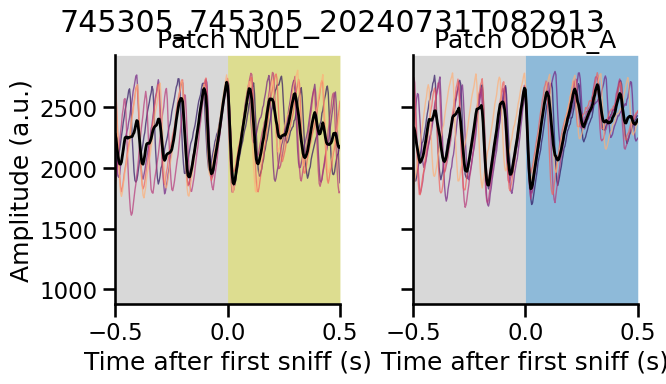

Processing session: 745305_20240801T083315


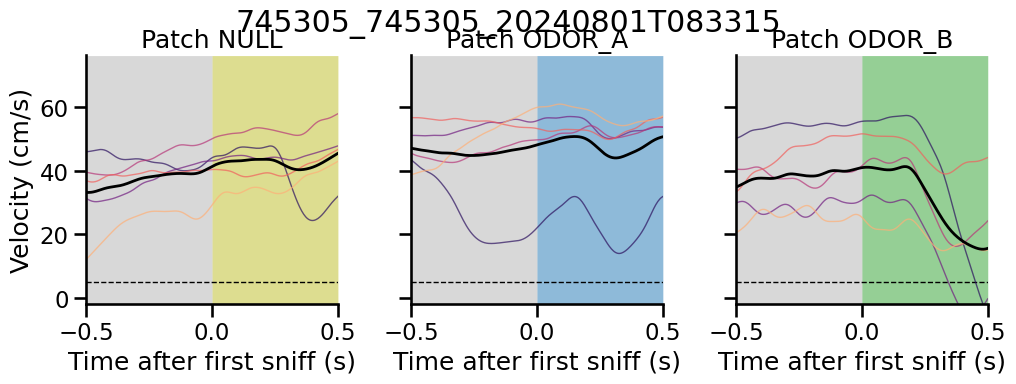

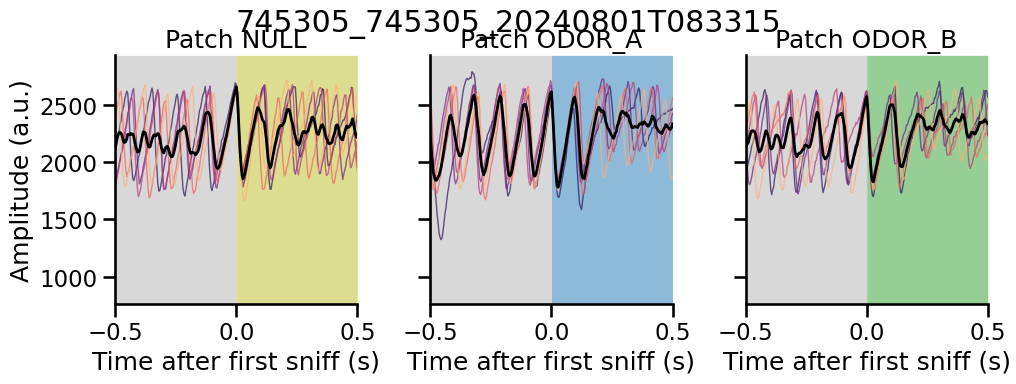

Processing session: 745305_20240802T083112


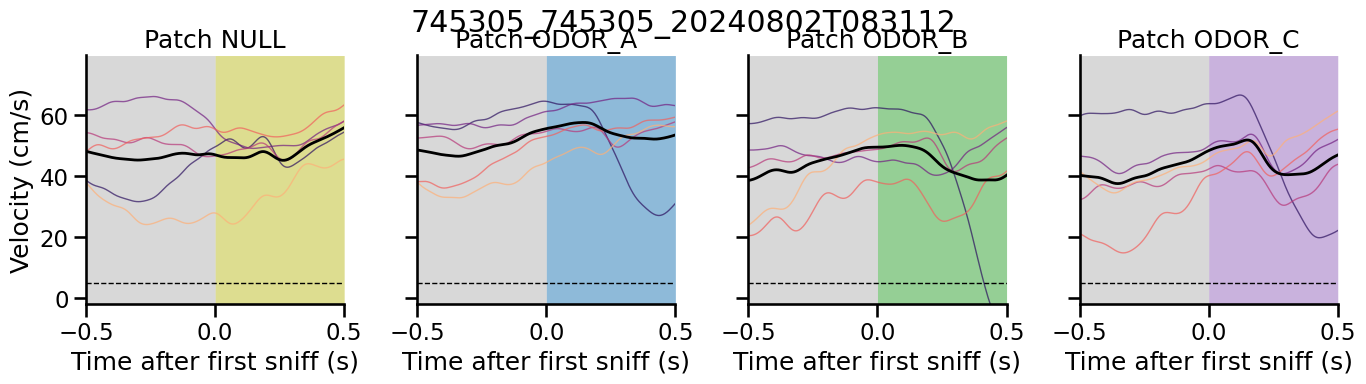

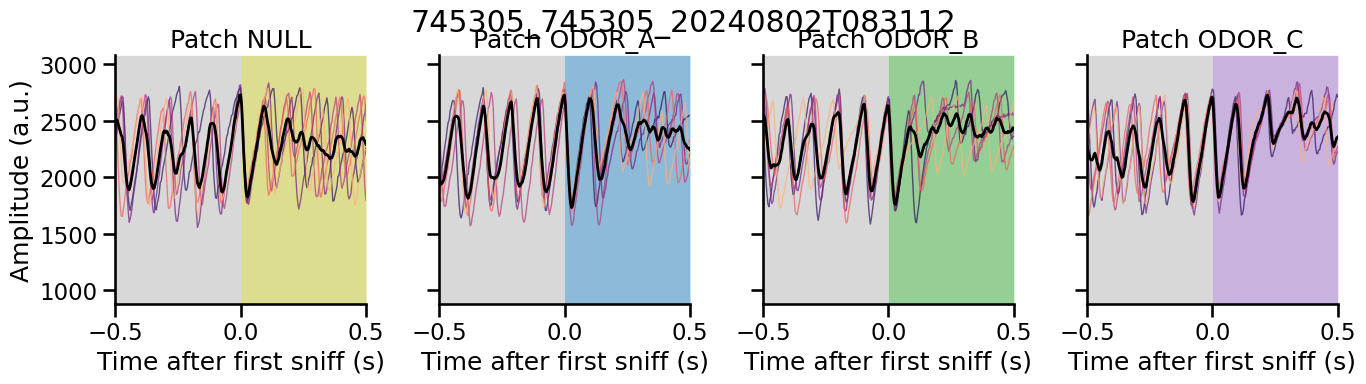

Processing session: 745305_20240803T111108


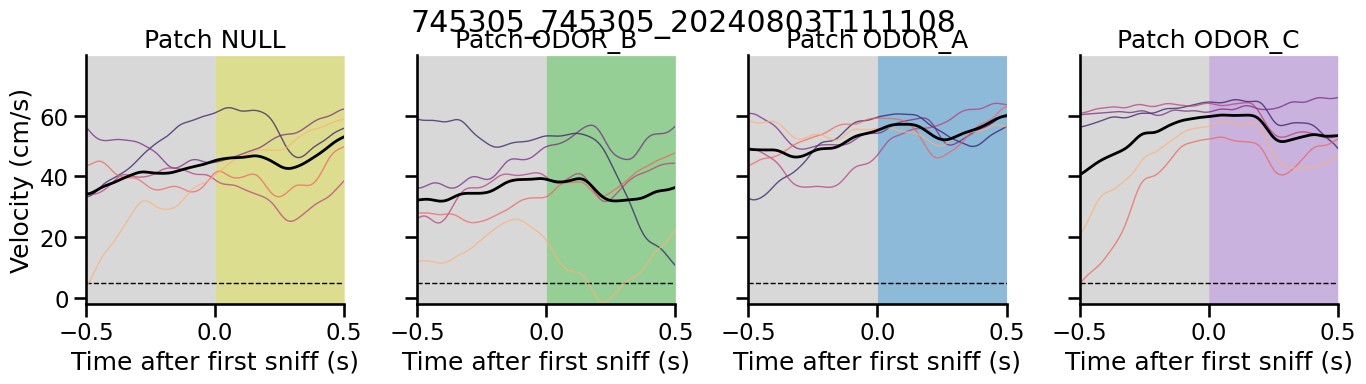

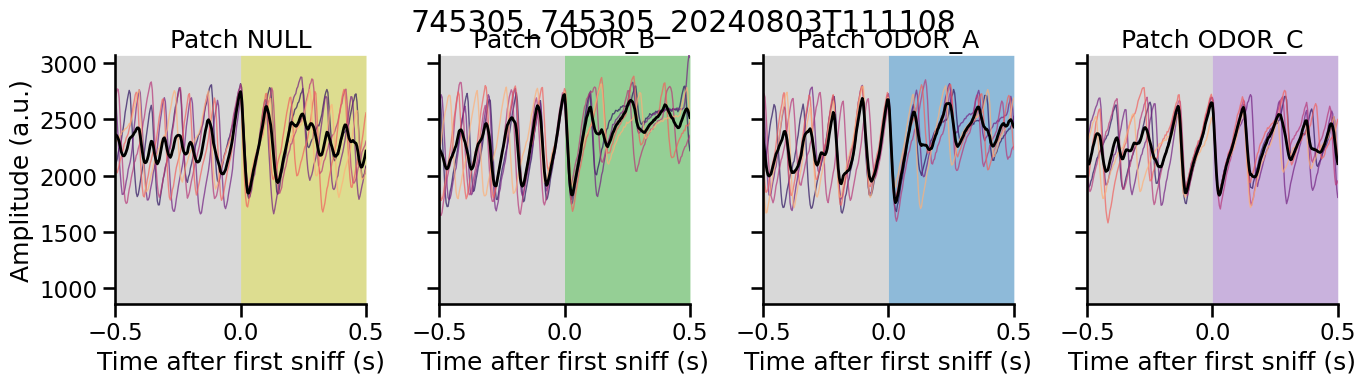

In [12]:
# Iterate over all sessions for the specified mouse
mouse_sessions_path = os.path.join(base_path, mouse_id)
for session_folder in os.listdir(mouse_sessions_path):
    session_path = os.path.join(mouse_sessions_path, session_folder)
    if os.path.isdir(session_path):
        process_session(session_path)

plt.show()  # Ensure that all figures are displayed in the end
